<a href="https://colab.research.google.com/github/jonbaer/googlecolab/blob/master/MmapNinjaRaggedMmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# mmap.ninja

This if a demo of `mmap_ninja`, which allows you to store your machine learning datasets in memory-mapped format during training.

This allows you to significantly speed up the I/O and accelerate the time for iteration over the dataset by up to **20 times**!

We'll demonstrate its power by converting an image segmentation dataset into 
a memory-mapped format.

In [ ]:
!pip install mmap_ninja

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for mmap-ninja: filename=mmap_ninja-0.2.1-py3-none-any.whl size=8095 sha256=4297551c9206f1ec2d51cdaec65accf9506f9c3a4a4628743bf4cd1afa238aa1
  Stored in directory: /root/.cache/pip/wheels/2f/da/3f/4794f761c01ddf0e0e8bd9a668ed4f91ca692437d7345a77ca
Successfully built mmap-ninja


In [ ]:
# Download the dataset
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# Extract images
!tar -xf images.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  21.3M      0  0:00:35  0:00:35 --:--:-- 22.6M


In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from os import listdir
from pathlib import Path
from tqdm import tqdm
from time import time

Let's have a quick a look at the dataset first.

The dataset consists of a directory of images in `jpg` format.

Number of images: 7390


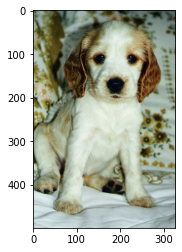

In [ ]:
input_dir = Path("images")

img_paths = [path for path in input_dir.iterdir() if path.suffix == '.jpg']
print(f'Number of images: {len(img_paths)}')
path_to_some_image = img_paths[0]
img = mpimg.imread(path_to_some_image)
plt.imshow(img)

Let's check how long does it take to make one iteration over the dataset of just reading the image.

This time will be added to the total training time of every epoch, so we should
make this as fast as possible.

In [ ]:
start_t = time()
for img_path in tqdm(img_paths):
  img = mpimg.imread(path_to_some_image)
total_t = time() - start_t
print(f'\nTime for iteration (s): {total_t}')

100%|██████████| 7390/7390 [00:33<00:00, 218.19it/s]


Time for iteration (s): 33.87720441818237


Now, let's convert the dataset into a `RaggedMmap`! It is called `Ragged`, because it can handle a dataset with different shapes, or even with different number of axes (e.g. you can mix grayscale images with RGB images)!

The first step is to convert the images into a `RaggedMmap`. 

This is done only once for the whole project, because it is persisted.

In [ ]:
from mmap_ninja.ragged import RaggedMmap

RaggedMmap.from_generator(
    out_dir='images_mmap',
    sample_generator=map(mpimg.imread, img_paths), 
    batch_size=1024, 
    verbose=True
)


7390it [01:02, 119.11it/s]


Now let's open the memory map and show an image

Number of images in memory map: 7390


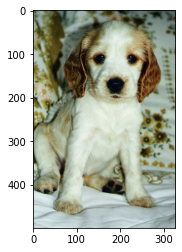

In [ ]:
images_mmap = RaggedMmap('images_mmap')

print(f'Number of images in memory map: {len(images_mmap)}')
plt.imshow(images_mmap[0])

In [ ]:
start_t = time()
for i in tqdm(range(len(images_mmap))):
  img = images_mmap[i]
total_mmap_t = time() - start_t
print(f'\nTime for iteration (s): {total_mmap_t}')

100%|██████████| 7390/7390 [00:00<00:00, 43220.05it/s]


Time for iteration (s): 0.17648649215698242


In [ ]:
ratio = total_t / total_mmap_t
print(f'We can see that the mmap_ninja is {ratio:.2f} times faster than storing the images as jpegs on the disk!')

We can see that the mmap_ninja is 191.95 times faster than storing the images as jpegs on the disk!


We've seen a dramatic improvement in the time for one iteration over the dataset.

It makes a big difference whether you are going to wait for one minute or one 
second!

Especially since this has to be done for every epoch, and every model you want
to experiment with, this quickly adds up!

**Quick tip**: If you want to apply a function when a given sample is loaded into memory, use the `wrapper_fn` argument.

For example, if you want `images_mmap[0]` to be returned as a PyTorch tensor:

In [ ]:
import torch
torch_mmap = RaggedMmap('images_mmap', wrapper_fn=torch.tensor)

In [ ]:
torch_mmap[0]


tensor([[[142, 155, 145],
         [130, 146, 120],
         [116, 130,  94],
         ...,
         [ 35,  49,  36],
         [ 33,  45,  33],
         [ 34,  44,  35]],

        [[137, 150, 130],
         [120, 134,  99],
         [ 99, 111,  65],
         ...,
         [ 49,  63,  50],
         [ 38,  50,  38],
         [ 38,  50,  38]],

        [[130, 140, 115],
         [113, 124,  82],
         [ 92, 101,  48],
         ...,
         [ 60,  73,  63],
         [ 55,  69,  56],
         [ 53,  67,  52]],

        ...,

        [[198, 216, 220],
         [199, 217, 221],
         [198, 216, 220],
         ...,
         [162, 181, 187],
         [166, 185, 192],
         [170, 187, 195]],

        [[200, 218, 222],
         [199, 217, 221],
         [197, 215, 219],
         ...,
         [160, 179, 185],
         [164, 183, 190],
         [165, 184, 191]],

        [[198, 216, 220],
         [198, 216, 220],
         [197, 215, 219],
         ...,
         [157, 178, 183],
        

**Another tip**: You can `append` or `extend` the `RaggedMmap`, in the same way you could with regular Python `list`s!

In [ ]:
print(len(images_mmap))

7391


In [ ]:
images_mmap.append(img)

In [ ]:
print(len(images_mmap))

7392


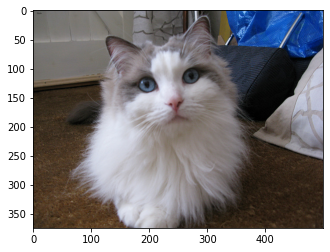

In [ ]:
plt.imshow(images_mmap[-1])

**Another tip**: To add multiple images to the memory map, just pass them as a list of numpy arrays to the `.extend` method:


In [ ]:
images_mmap.extend([img, img])

In [ ]:
len(images_mmap)

7394

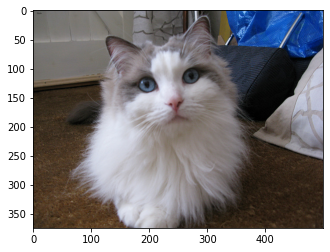

In [ ]:
plt.imshow(images_mmap[-1])